In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import xarray as xr
import os

import utils

In [2]:
path = os.getcwd()

In [3]:
data_daily = utils.munich_station_daily(location=path, to_xarray=True)
data_10min = utils.munich_station_10min(location=path, to_xarray=True).rename(t = 't_mean')

In [4]:
data_daily

<xarray.Dataset>
Dimensions:   (time: 23955)
Coordinates:
  * time      (time) datetime64[ns] 1954-06-01 1954-06-02 ... 2019-12-31
Data variables:
    t_mean    (time) float64 14.0 13.2 16.6 15.2 15.2 ... 3.7 -0.1 -1.6 0.0 3.0
    t_max     (time) float64 17.6 19.7 21.9 17.3 17.7 ... 4.9 2.0 2.5 6.0 8.6
    t_min     (time) float64 10.4 9.7 8.2 11.8 13.7 ... 1.7 -2.1 -4.8 -4.4 -0.5
    precip    (time) float64 0.0 0.5 0.0 1.2 6.0 2.3 ... 1.5 4.9 0.0 0.0 0.0 0.0
    pressure  (time) float64 -999.0 -999.0 -999.0 -999.0 ... 974.7 970.9 969.5

In [5]:
data_10min

<xarray.Dataset>
Dimensions:  (time: 29126)
Coordinates:
  * time     (time) datetime64[ns] 2018-10-04 ... 2019-04-24T06:10:00
Data variables:
    t_mean   (time) float64 9.2 9.0 8.9 8.9 8.9 8.9 ... 14.6 14.9 15.4 15.9 16.5

In [6]:
# use daily data to compute seasonal cycle

seasonal_cycle = data_daily.groupby("time.dayofyear").mean()

# remove seasonal cycle from daily and 10min data

anom_daily = data_daily.groupby("time.dayofyear") - seasonal_cycle
anom_10min_with_diurnal_cycle = data_10min.groupby("time.dayofyear") - seasonal_cycle

# use 10min data to compute diurnal cycle
diurnal_cycle = anom_10min_with_diurnal_cycle.groupby("time.hour").mean()

# remove diurnal cycle from 10min data:
anom_10min = anom_10min_with_diurnal_cycle.groupby("time.hour") - diurnal_cycle

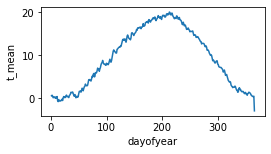

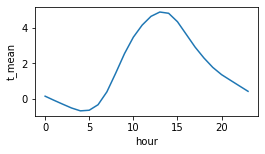

In [7]:
# visualize seasonal and diurnal cycle for temperature
seasonal_cycle.t_mean.plot(figsize=(4,2))
plt.show()
diurnal_cycle.t_mean.plot(figsize=(4,2))
plt.show()

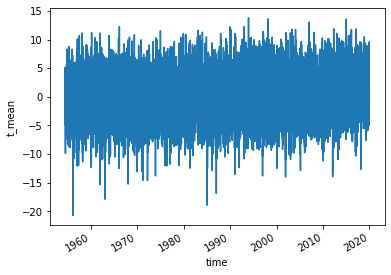

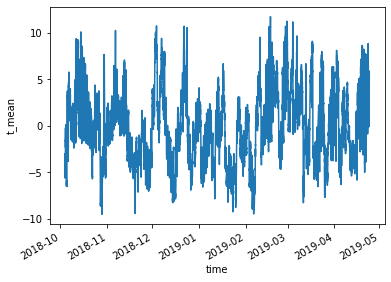

In [8]:
anom_daily.t_mean.plot()
plt.show()
anom_10min.t_mean.plot()
plt.show()

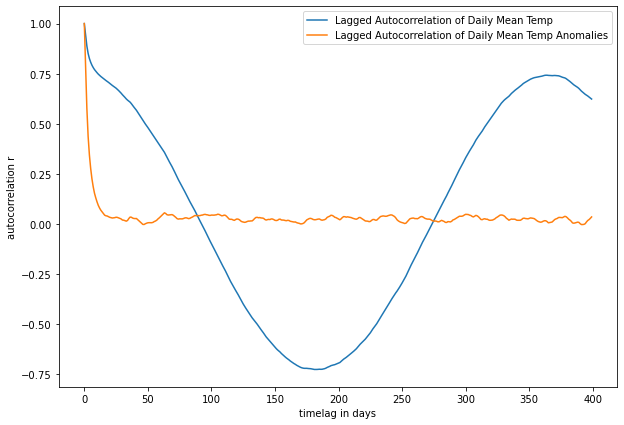

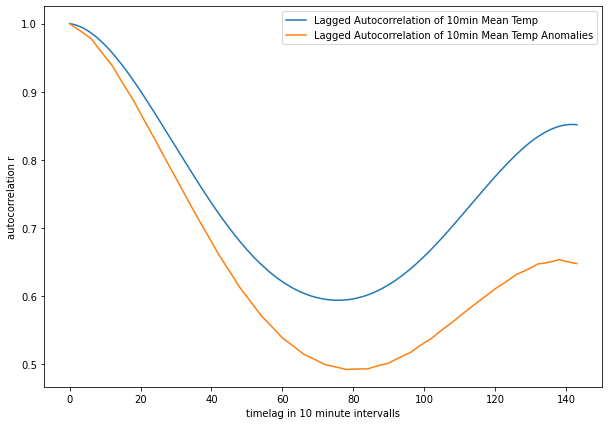

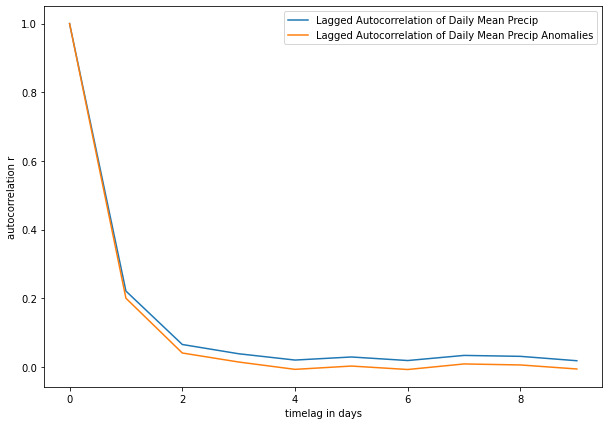

In [11]:
#compute lagged autocorrelation 
timelag = range(0,400,1)
timelag_10min = range(0, 24*6, 1)
timelag_precip = range(0,10,1)

autocorr_tmean = np.zeros(len(timelag)) 
autocorr_tmean_anom  = np.zeros(len(timelag))
autocorr_10min  = np.zeros(len(timelag_10min))
autocorr_10min_anom  = np.zeros(len(timelag_10min))
autocorr_precip = np.zeros(len(timelag_precip))
autocorr_precip_anom  = np.zeros(len(timelag_precip))

for i in timelag:
    autocorr_tmean_anom[i] = xr.corr(anom_daily.t_mean, anom_daily.t_mean.shift(time = -i))
    autocorr_tmean[i] = xr.corr(data_daily.t_mean, data_daily.t_mean.shift(time = -i))
for i in timelag_precip:
    autocorr_precip[i] = xr.corr(data_daily.precip, data_daily.precip.shift(time = -i))
    autocorr_precip_anom[i] = xr.corr(anom_daily.precip, anom_daily.precip.shift(time = -i))
for i in timelag_10min:
    autocorr_10min[i] = xr.corr(data_10min.t_mean, data_10min.t_mean.shift(time = -i))
    autocorr_10min_anom[i] = xr.corr(anom_10min.t_mean, anom_10min.t_mean.shift(time = -i))
    
    
fig = plt.figure(figsize = (10,7))
plt.plot(timelag, autocorr_tmean, label = 'Lagged Autocorrelation of Daily Mean Temp')
plt.plot(timelag, autocorr_tmean_anom, label = 'Lagged Autocorrelation of Daily Mean Temp Anomalies')
plt.legend()
plt.xlabel('timelag in days')
plt.ylabel('autocorrelation r')
plt.show()

fig2 = plt.figure(figsize = (10,7))
plt.plot(timelag_10min, autocorr_10min, label = 'Lagged Autocorrelation of 10min Mean Temp')
plt.plot(timelag_10min, autocorr_10min_anom, label = 'Lagged Autocorrelation of 10min Mean Temp Anomalies')
plt.legend()
plt.xlabel('timelag in 10 minute intervalls')
plt.ylabel('autocorrelation r')
plt.show()

fig3 = plt.figure(figsize = (10,7))
plt.plot(timelag_precip, autocorr_precip, label = 'Lagged Autocorrelation of Daily Mean Precip')
plt.plot(timelag_precip, autocorr_precip_anom, label = 'Lagged Autocorrelation of Daily Mean Precip Anomalies')
plt.legend()
plt.xlabel('timelag in days')
plt.ylabel('autocorrelation r')
plt.show()

In [22]:
#perform student´s t-tests to see if temp_mean from 2000-09 is significantly different from temp_mean in 2010-19

mean1 = anom_daily.t_mean.sel(time = slice('2000', '2009')).mean()
mean2 = anom_daily.t_mean.sel(time = slice('2010', '2019')).mean()
std1 = anom_daily.t_mean.sel(time = slice('2000', '2009')).std()
std2 = anom_daily.t_mean.sel(time = slice('2010', '2019')).std()
nobs1 = len(anom_daily.t_mean.sel(time = slice('2000', '2009')))
nobs2 = len(anom_daily.t_mean.sel(time = slice('2010', '2019')))

nobs1_leith = nobs1 * np.log(autocorr_tmean_anom[1]) / (-2)
nobs2_leith = nobs2 * np.log(autocorr_tmean_anom[1]) / (-2)

nobs1_bret = nobs1 * (1-autocorr_tmean_anom[1]) / (1+autocorr_tmean_anom[1])
nobs2_bret = nobs2 * (1-autocorr_tmean_anom[1]) / (1+autocorr_tmean_anom[1])

print('p-value with N: \np =', scipy.stats.ttest_ind_from_stats(mean1 , std1 , nobs1 , mean2 , std2 , nobs2).pvalue)
print('p-value with Leith N: \np =', scipy.stats.ttest_ind_from_stats(mean1 , std1 , nobs1_leith, mean2 , std2 , nobs2_leith).pvalue)
print('p-value with Bretherton N: \np =', scipy.stats.ttest_ind_from_stats(mean1 , std1 , nobs1_bret , mean2 , std2 , nobs2_bret).pvalue)

p-value with N: 
p = 1.0512941810955984e-05
p-value with Leith N: 
p = 0.1343555373946001
p-value with Bretherton N: 
p = 0.1352205800968559
